<img src="https://hilpisch.com/tpq_logo_bic.png"
     width="30%"
     align="right"
     style="border-radius: 8px;">

# Derivatives Analytics with Python
**&mdash;Part IIIa: Market-Based Valuation (Ch.&nbsp;8&ndash;10)**

&copy; Dr. Yves J. Hilpisch | The Python Quants

<a href="https://tpq.io" target="_blank">tpq.io</a> | <a href="https://linktr.ee/dyjh" target="_blank">linktr.ee/dyjh</a>

<img src="https://hilpisch.com/dawp_cover_small.png" width=30% align=left>

## Part IIIa &mdash; Market-Based Valuation

### Chapter 8 &mdash; A First Example of Market-Based Valuation

This notebook implements an end-to-end market-based valuation workflow:

- Choose a model that can represent observed option prices.
- Value European calls under the model by numerical integration and by FFT.
- Calibrate model parameters to option market data across maturities.
- Validate the calibrated model with simulation-based valuation.

Reference notebooks and scripts for the book are available under `x_store/dawp/python36`.

The notebook is designed to run smoothly on Google Colab. A local setup is optional and
can be based on `python -m venv .venv`.

### 1. Environment check

We start by importing the core libraries for this class and by printing version
information to confirm that a modern Python environment is active.

In [1]:
import sys  # access basic runtime information
from pathlib import Path  # path handling for data and figure export

import math  # elementary math functions

import numpy as np  # numerical arrays
import pandas as pd  # tabular data handling
import matplotlib as mpl  # matplotlib configuration
import matplotlib.pyplot as plt  # plotting

from numpy.fft import fft  # fast Fourier transform
from numpy.random import default_rng  # random number generator

from scipy.integrate import quad  # numerical integration
import scipy.optimize as sop  # numerical optimization

np.set_printoptions(precision=6, suppress=True)  # compact numeric output

print(sys.version.split()[0])  # Python version string
print("NumPy:", np.__version__)  # NumPy version string
print("pandas:", pd.__version__)  # pandas version string

FIG_SAVE = True  # set to True to export figures as PDFs
FIG_DIR = Path("../figures")  # figure output directory
FIG_DPI = 300  # target resolution for exported figures
FIG_DISPLAY = "svg"  # inline display format: "svg" or "png"

plt.style.use("seaborn-v0_8")  # readable plotting defaults
mpl.rcParams["figure.figsize"] = (8.0, 4.5)  # consistent figure size
mpl.rcParams["axes.grid"] = True  # show a grid for readability
mpl.rcParams["savefig.dpi"] = FIG_DPI  # default export resolution

try:
    from matplotlib_inline.backend_inline import (  # Jupyter helper
        set_matplotlib_formats,
    )
    set_matplotlib_formats(FIG_DISPLAY)  # configure inline plot rendering
except Exception:
    pass

if FIG_DISPLAY == "png":
    mpl.rcParams["figure.dpi"] = FIG_DPI  # high-resolution inline rendering


def maybe_save(fig, filename):
    # Optionally saves a Matplotlib figure as a PDF file.
    if not FIG_SAVE:
        return
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    path = FIG_DIR / f"{filename}.pdf"
    fig.savefig(path, format="pdf", dpi=FIG_DPI)
    print(f"saved: {path}")

3.11.13
NumPy: 2.3.5
pandas: 2.3.3


### 2. Option market data

We load European option quotes from a local HDF5 file. The dataset contains calls and puts
for several maturities and strikes (EURO STOXX 50 options, 30 September 2014).

In [2]:
DATA_PATH = Path("../code/dawp_pIIIa_ch08_option_data.h5")  # local market data file

data = pd.read_hdf(DATA_PATH, key="data")  # options table
data = data.copy()  # avoid chained assignment issues

data["Date"] = pd.to_datetime(data["Date"])  # valuation date
data["Maturity"] = pd.to_datetime(data["Maturity"])  # maturity date
data["T"] = (data["Maturity"] - data["Date"]).dt.days / 365.0
  # time to maturity in years

data[["Date", "Maturity", "Strike", "Call", "Put", "T"]].head(10)

,Date,Maturity,Strike,Call,Put,T
0,2014-09-30,2014-12-19,1850.0,1373.6,0.5,0.219178
1,2014-09-30,2014-12-19,1900.0,1323.7,0.6,0.219178
2,2014-09-30,2014-12-19,1950.0,1273.8,0.8,0.219178
3,2014-09-30,2014-12-19,2000.0,1223.9,0.9,0.219178
4,2014-09-30,2014-12-19,2050.0,1174.1,1.1,0.219178
5,2014-09-30,2014-12-19,2100.0,1124.3,1.3,0.219178
6,2014-09-30,2014-12-19,2150.0,1074.5,1.5,0.219178
7,2014-09-30,2014-12-19,2200.0,1024.8,1.7,0.219178
8,2014-09-30,2014-12-19,2250.0,975.1,2.1,0.219178
9,2014-09-30,2014-12-19,2300.0,925.4,2.4,0.219178


### 3. Merton (1976) jump diffusion model

We use Merton's jump diffusion model as the market model. Under the risk-neutral measure,
the log-return combines a diffusion part and a compound Poisson jump part.

Fourier-based pricing relies on the characteristic function of the log-return,
$$\varphi_T(u)=\mathbb{E}^{\mathbb{Q}}[e^{iuX_T}],\qquad X_T=\log(S_T/S_0).$$

In [3]:
def m76_char_func(u, T, r, sigma, lamb, mu, delta):
    # Characteristic function of X_T = log(S_T / S_0) under risk-neutral dynamics.
    kappa = math.exp(mu + 0.5 * delta * delta) - 1.0
      # mean jump size minus one
    omega = r - 0.5 * sigma * sigma - lamb * kappa
      # risk-neutral drift of the log-return

    diff = 1j * u * omega - 0.5 * sigma * sigma * u * u
      # diffusion term
    jump = lamb * (np.exp(1j * u * mu - 0.5 * delta * delta * u * u) - 1.0)
      # compound Poisson jump term
    return np.exp((diff + jump) * T)


### 4. Valuation by numerical integration (Lewis)

Lewis-style pricing expresses the call value as a single integral involving the
characteristic function evaluated at a complex argument.

The method is robust and provides a reference for other numerical approaches.

In [4]:
def m76_call_value_int(S0, K, T, r, sigma, lamb, mu, delta, u_max=50.0):
    # European call value via Lewis (2001) Fourier integral representation.
    def integrand(u):
        # Integrand for the pricing formula.
        cf = m76_char_func(u - 0.5j, T, r, sigma, lamb, mu, delta)
        num = np.exp(1j * u * math.log(S0 / K)) * cf
          # complex numerator
        den = u * u + 0.25  # integrability denominator
        return (num / den).real

    integral = quad(lambda x: integrand(x), 0.0, u_max, limit=250)[0]
      # numerical integral approximation
    factor = math.exp(-r * T) * math.sqrt(S0 * K) / math.pi
      # integral prefactor
    return float(S0 - factor * integral)


### 5. Valuation by FFT (Carr&mdash;Madan)

FFT-based pricing is efficient for repeated valuations across a strike set, which is
particularly useful during calibration.

In [5]:
def m76_call_value_fft(S0, K, T, r, sigma, lamb, mu, delta, g=2):
    # European call value via Carr-Madan FFT pricing (single strike via lookup).
    k = math.log(K / S0)  # log-strike in terms of K/S0
    N = g * 4096  # FFT grid size
    eps = (g * 150.0) ** -1  # log-strike grid spacing
    eta = 2.0 * math.pi / (N * eps)  # Fourier grid spacing
    b = 0.5 * N * eps - k  # shift for strike alignment

    u = np.arange(1, N + 1)  # grid indices
    v0 = eta * (u - 1)  # Fourier grid

    if S0 >= 0.95 * K:
        alpha = 1.5  # damping parameter for ITM
        v = v0 - (alpha + 1.0) * 1j  # complex CF argument
        mod_cf = math.exp(-r * T) * m76_char_func(v, T, r, sigma, lamb, mu, delta)
          # discounted characteristic function
        den = alpha * alpha + alpha - v0 * v0 + 1j * (2.0 * alpha + 1.0) * v0
          # Carr-Madan denominator
        psi = mod_cf / den  # modified transform
    else:
        alpha = 1.1  # damping parameter for OTM
        v = (v0 - 1j * alpha) - 1j  # complex CF argument
        term = 1.0 / (1.0 + 1j * (v0 - 1j * alpha))
        term -= math.exp(r * T) / (1j * (v0 - 1j * alpha))
        term -= m76_char_func(v, T, r, sigma, lamb, mu, delta) / (
            (v0 - 1j * alpha) ** 2 - 1j * (v0 - 1j * alpha)
        )
        psi_1 = math.exp(-r * T) * term  # first transform

        v = (v0 + 1j * alpha) - 1j  # complex CF argument
        term = 1.0 / (1.0 + 1j * (v0 + 1j * alpha))
        term -= math.exp(r * T) / (1j * (v0 + 1j * alpha))
        term -= m76_char_func(v, T, r, sigma, lamb, mu, delta) / (
            (v0 + 1j * alpha) ** 2 - 1j * (v0 + 1j * alpha)
        )
        psi_2 = math.exp(-r * T) * term  # second transform

    delt = np.zeros(N)  # Simpson delta vector
    delt[0] = 1.0
    j = np.arange(1, N + 1)  # Simpson index vector
    w = (3.0 + (-1.0) ** j - delt) / 3.0  # Simpson weights

    if S0 >= 0.95 * K:
        fft_func = np.exp(1j * b * v0) * psi * eta * w  # FFT input
        payoff = fft(fft_func).real  # FFT output
        c_m = np.exp(-alpha * k) / math.pi * payoff  # call grid
    else:
        fft_func = np.exp(1j * b * v0) * (psi_1 - psi_2) * 0.5 * eta * w
          # FFT input
        payoff = fft(fft_func).real  # FFT output
        c_m = payoff / (np.sinh(alpha * k) * math.pi)  # call grid

    pos = int((k + b) / eps)  # strike position on the grid
    return float(c_m[pos] * S0)


### 6. Valuation by Monte Carlo simulation

Simulation under Merton dynamics combines diffusion increments and Poisson jump draws.
For a European call, the estimator is the discounted payoff average.

In [6]:
def m76_call_value_mcs(
    S0,
    K,
    T,
    r,
    sigma,
    lamb,
    mu,
    delta,
    n_steps,
    n_paths,
    seed=10,
):
    # European call value via Monte Carlo simulation in the Merton model.
    dt = T / n_steps  # time step length
    disc = math.exp(-r * T)  # discount factor to time 0

    kappa = math.exp(mu + 0.5 * delta * delta) - 1.0
      # mean jump size minus one
    drift = (r - lamb * kappa - 0.5 * sigma * sigma) * dt
      # risk-neutral drift for log Euler
    vol = sigma * math.sqrt(dt)  # diffusion scale per step

    rng = default_rng(seed)  # random number generator
    Z = rng.standard_normal((n_steps, n_paths))  # diffusion shocks
    J = rng.standard_normal((n_steps, n_paths))  # jump size shocks
    N = rng.poisson(lamb * dt, (n_steps, n_paths))  # jump counts

    log_jump = mu * N + delta * np.sqrt(N) * J
      # aggregated log jump sizes per step
    log_increments = drift + vol * Z + log_jump  # log increments

    S_T = S0 * np.exp(np.sum(log_increments, axis=0))  # terminal stock levels
    payoff = np.maximum(S_T - K, 0.0)  # terminal call payoff
    return float(disc * np.mean(payoff))


### 7. Method comparison figure

We compare call values across strikes computed by numerical integration, FFT, and Monte
Carlo simulation. The exported figure is used in the Part IIIa slide deck.

saved: ../figures/dawp_pIIIa_fig01_m76_methods_compare.pdf


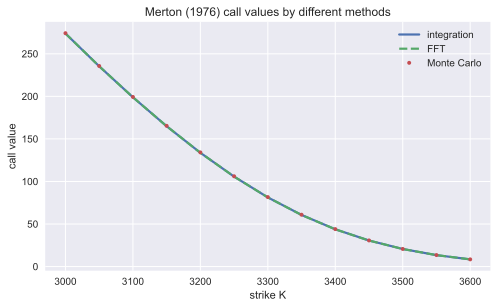

In [7]:
S0 = 3225.93  # EURO STOXX 50 level (30.09.2014)
r = 0.005  # short rate assumption
T = 0.22  # short maturity (approx.)

sigma = 0.124  # diffusion volatility
lamb = 1.393  # jump intensity
mu = -0.137  # mean log jump size
delta = 0.000  # log jump volatility

strikes = np.arange(3000.0, 3601.0, 50.0)  # strike grid

v_int = np.array([m76_call_value_int(S0, k, T, r, sigma, lamb, mu, delta)
                  for k in strikes])
v_fft = np.array([m76_call_value_fft(S0, k, T, r, sigma, lamb, mu, delta)
                  for k in strikes])
v_mcs = np.array([
    m76_call_value_mcs(
        S0,
        k,
        T,
        r,
        sigma,
        lamb,
        mu,
        delta,
        n_steps=50,
        n_paths=30_000,
        seed=10,
    )
    for k in strikes
])

fig, ax = plt.subplots()  # create a single plot
ax.plot(strikes, v_int, lw=2.2, label="integration")
ax.plot(strikes, v_fft, lw=2.2, ls="--", label="FFT")
ax.plot(strikes, v_mcs, lw=0.0, marker="o", ms=4, label="Monte Carlo")

ax.set_xlabel("strike K")
ax.set_ylabel("call value")
ax.set_title("Merton (1976) call values by different methods")
ax.legend(loc=0)

maybe_save(fig, "dawp_pIIIa_fig01_m76_methods_compare")  # optional PDF export
plt.show()

### 8. Calibration to market quotes (three maturities)

We calibrate $(\sigma, \lambda, \mu, \delta)$ by minimizing the root mean squared error
between model call prices and observed market call prices, using FFT-based valuation.

To keep the example compact, we calibrate on near-the-money strikes across all maturities.

In [8]:
def rmse(model_vals, market_vals):
    # Root mean squared error for model vs market prices.
    diff = np.asarray(model_vals) - np.asarray(market_vals)
    return float(np.sqrt(np.mean(diff * diff)))


def calibrate_m76_fft(options, S0, r):
    # Calibrates M76 parameters by minimizing RMSE across the option set.
    strikes = options["Strike"].to_numpy()
    calls = options["Call"].to_numpy()
    times = options["T"].to_numpy()

    def objective(p):
        # Objective function returning RMSE for a parameter vector.
        sigma, lamb, mu, delta = p
        if sigma <= 0.0 or delta < 0.0 or lamb < 0.0:
            return 1e6
        model = [
            m76_call_value_fft(S0, K, t, r, sigma, lamb, mu, delta)
            for K, t in zip(strikes, times)
        ]
        return rmse(model, calls)

    x0 = np.array([0.12, 1.0, -0.12, 0.10])
    bounds = [(0.02, 0.50), (0.0, 5.0), (-0.50, 0.05), (0.0, 0.50)]

    res = sop.minimize(
        objective,
        x0,
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 250},
    )
    return res


S0 = 3225.93  # EURO STOXX 50 level
r = 0.0005  # short rate proxy

tol = 0.02  # relative strike window around S0
opt = data[(np.abs(data["Strike"] - S0) / S0) < tol].copy()

res = calibrate_m76_fft(opt, S0, r)
print("Calibration success:", bool(res.success))
print("RMSE:", float(res.fun))
print("sigma, lambda, mu, delta:", res.x)

Calibration success: True
RMSE: 3.211477073070383
sigma, lambda, mu, delta: [ 0.109284  5.       -0.053753  0.      ]


### 9. Calibration fit figure

We visualize the calibration fit by comparing market call prices to the calibrated model
values across strikes, separately for each maturity. The exported figure is used in the
Part IIIa slide deck.

saved: ../figures/dawp_pIIIa_fig02_m76_calibration_fit.pdf


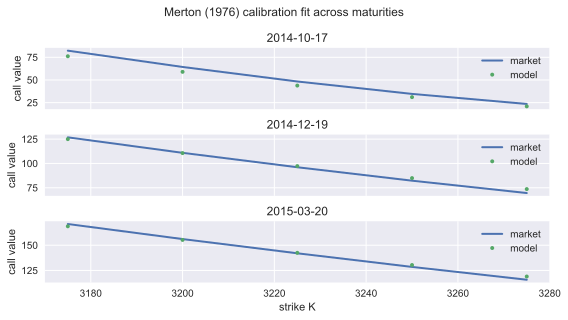

In [9]:
sigma, lamb, mu, delta = res.x  # calibrated parameters

opt = opt.copy()  # work on a copy
opt["Model"] = [
    m76_call_value_fft(S0, K, T, r, sigma, lamb, mu, delta)
    for K, T in zip(opt["Strike"], opt["T"])
]

mats = sorted(opt["Maturity"].unique())  # maturities in the data
fig, axes = plt.subplots(len(mats), 1, sharex=True)
if len(mats) == 1:
    axes = [axes]

for ax, mat in zip(axes, mats):
    sub = opt[opt["Maturity"] == mat].sort_values("Strike")
    ax.plot(sub["Strike"], sub["Call"], lw=2.0, label="market")
    ax.plot(sub["Strike"], sub["Model"], lw=0.0, marker="o", ms=4,
            label="model")
    ax.set_ylabel("call value")
    ax.set_title(str(mat)[:10])
    ax.legend(loc=0)

axes[-1].set_xlabel("strike K")
fig.suptitle("Merton (1976) calibration fit across maturities")
fig.tight_layout()

maybe_save(fig, "dawp_pIIIa_fig02_m76_calibration_fit")  # optional PDF export
plt.show()

### 10. Summary

This chapter-level example demonstrates how market quotes, valuation methods, calibration,
and simulation combine into a practical market-based valuation workflow.

<img src="https://hilpisch.com/tpq_logo_bic.png"
     width="30%"
     align="right"
     style="border-radius: 8px;">